In [41]:
import numpy as np
import pandas as pd
import math
import time
import ripser
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

In [34]:
def n_sphere(point_num, dim):
    r = np.random.normal(5, (0.1)**(dim-1)*5, (1,point_num))   
    coordi = np.ones((dim-1, point_num))              
    for i in range(0, dim-2):                    
        coordi[i] = (np.pi)*np.random.rand(1,point_num)
    coordi[dim-2] = 2*(np.pi)*np.random.rand(1,point_num) 

    point = r * np.ones((dim, point_num)) 
    
    for i in range(0, dim-1):              
        point[i] *= np.cos(coordi[i])
    
    for i in range(1, dim):              
        for j in range(0, i):
            point[i] *= np.sin(coordi[j]) 
        
    point = point.T    
    scaler = MinMaxScaler()
    point = scaler.fit_transform(point)
    return point

In [35]:
def char_ltc_alg(data_arr, reduction_rate):
    scaler = MinMaxScaler()
    data_arr = scaler.fit_transform(data_arr)
    chosen_points = int(len(data_arr) * (1-reduction_rate))
    delta = 1/(math.ceil(np.sqrt(chosen_points)))
    for i in np.arange(0,1,0.001):
        new_arr = (data_arr // delta) * delta + delta/2
        new_arr = np.unique(new_arr, axis=0)       # Deduplication
        if new_arr.shape[0] <= chosen_points :
            break
        delta -= i
    return new_arr

def k_meanspp(data_arr,chosen_points):
    kmeans = KMeans(n_clusters=chosen_points, n_init='auto',init='k-means++')
    kmeans.fit(data)
    return kmeans.cluster_centers_

def randomly(data_arr,chosen_points):
    return data_arr[np.random.choice(data_arr.shape[0], chosen_points, replace=False), :]

def maxmin_alg(data_points,chosen_num):
    idx = np.random.choice(data_points.shape[0],1)
    chosen_points = [data_points[idx[0],:]]
    data_points = np.delete(data_points, idx, axis=0)

    while chosen_num != len(chosen_points):
        ft_dict = {}
        for pt_idx, pt in enumerate(data_points):
            ft_dict[pt_idx] = np.min([np.linalg.norm(pt-chosen_pt) for chosen_pt in chosen_points])
            idx = max(ft_dict, key=ft_dict.get)
        chosen_points += [data_points[idx,:]]
        data_points = np.delete(data_points, idx, axis=0)
    return np.array(chosen_points)

In [36]:
dimension = 2
np.random.seed(1)
data = n_sphere(1000,dimension)
save_pre_time = dict()
save_pd_time = dict()

In [40]:
# In [20], data_size/chosen_pt >= 20 seems to work quite well for data sampled from a two-dimensional surface.

tick= time.time()
result_cla = char_ltc_alg(data,0.95)
tock = time.time()-tick
save_pre_time['CLA'] = round(tock,6)

tick= time.time()
result_kmeans = k_meanspp(data,50)
tock = time.time()-tick
save_pre_time['KMeans'] = round(tock,6)

tick= time.time()
result_random = randomly(data,50)
tock = time.time()-tick
save_pre_time['random'] = round(tock,6)

tick= time.time()
result_maxmin = maxmin_alg(data,50)
tock = time.time()-tick
save_pre_time['MaxMin'] = round(tock,6)

results_list = [result_cla, result_kmeans, result_random, result_maxmin]
for idx, key in enumerate(save_pre_time.keys()):
    tick= time.time()
    diagrams = ripser.ripser(results_list[idx],maxdim=dimension-1)
    tock = time.time()-tick
    save_pd_time[str(key)] = round(tock,6)

print("Run time(sec) of preprocessing:",save_pre_time)
print("Run time(sec) of persistent diagram:",save_pd_time)

Run time(sec) of preprocessing: {'CLA': 0.001917, 'KMeans': 0.01064, 'random': 0.000115, 'MaxMin': 2.57787}
Run time(sec) of persistent diagram: {'CLA': 0.000879, 'KMeans': 0.000701, 'random': 0.000625, 'MaxMin': 0.000585}


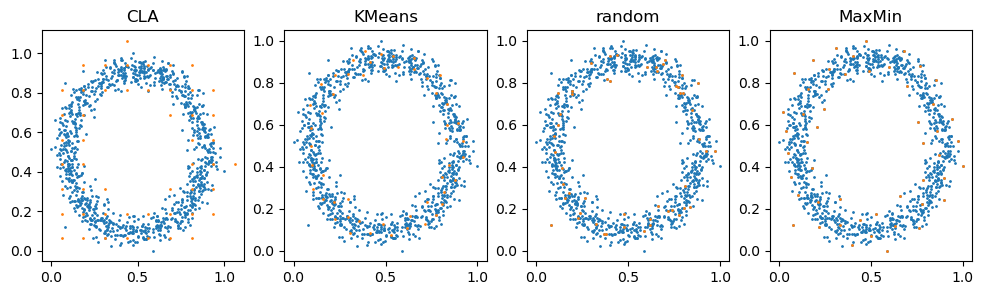

In [38]:
plt.figure(figsize=(12,3))
for idx, key in enumerate(save_pre_time.keys()):
    plt.subplot(1,4,idx+1)
    plt.scatter(data[:,0],data[:,1], s=1)
    plt.scatter(results_list[idx][:,0],results_list[idx][:,1],s=1)    
    plt.title(key)
plt.show()


---

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [26]:
save_acc = dict()

In [27]:
def persistent_dgrms(data_arr,dimension):
    data_arr = ripser.ripser(data_arr,maxdim=dimension-1)['dgms']
    data_arr = np.concatenate(data_arr)
    data_arr[data_arr == np.inf] = 0
    return data_arr

def make_svm_data(data_size,point_num,pre_alg,chosen_points):
    temp = []
    for sd in range(int(data_size/2)):
        np.random.seed(sd)
        
        sphere = n_sphere(point_num,2)
        pre_sphere = pre_alg(sphere, chosen_points)
        temp.append(persistent_dgrms(pre_sphere,2))
        
        random = np.random.rand(point_num, 2)
        pre_random = pre_alg(random, chosen_points)
        temp.append(persistent_dgrms(pre_random,2))
    
    length = max([tmp.shape[0] for tmp in temp])
    data = np.zeros([data_size,length*2])
    for idx, tmp in enumerate(temp):
        tmp = tmp.reshape(1,-1)
        data[idx,:tmp.shape[1]] = tmp
    
    label = [0,1]*int(data_size/2)
    return data, label

def svm_progress(data,label):
    X = pd.DataFrame(data)
    y = label

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42,stratify=y)

    svm = SVC()
    svm.fit(X_train, y_train)
    y_preds = svm.predict(X_test)
    return accuracy_score(y_test,y_preds)

In [28]:
X, y = make_svm_data(1000,1000,char_ltc_alg,0.95)
save_acc['CLA'] = svm_progress(X,y)

In [29]:
X, y = make_svm_data(1000,1000,k_meanspp,50)
save_acc['KMeans'] = svm_progress(X,y)

In [30]:
X, y = make_svm_data(1000,1000,randomly,50)
save_acc['random'] = svm_progress(X,y)

In [14]:
X, y = make_svm_data(1000,1000,maxmin_alg,50)
save_acc['MaxMin'] = svm_progress(X,y)

In [15]:
save_acc

{'CLA': 1.0, 'KMeans': 0.46, 'random': 1.0, 'MaxMin': 1.0}